# Cluster membership probability

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

# Astrometric solution

Open the file which contains the parameter values for each star in GES

In [2]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

# 1.2 Cluster choice

Choosing a good globular cluster according to Clare's recommendation. 


In [3]:
GC=data[data['GES_FLD']=='NGC104'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in GC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)

# 1.3 Gaia Data input

In [4]:
ra=GC['RA'].astype(float)
dec=GC['DEC'].astype(float)
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius
selection_region=gaia_cone(center[0],center[1],radius*0.5*0.5*0.75)

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 6.0253899470450785, -72.07755733533718)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 6.0253899470450785, -72.07755733533718, 0.25477240580526855)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Thu, 24 Feb 2022 17:19:43 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=bloc

# 1.4 Visualising the sample

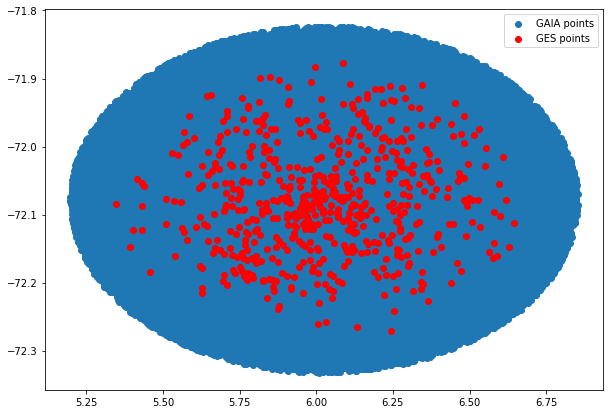

In [5]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

# 1.5 Merging dataframes

We want to have a dataframe and if theres a match in GES then that column gets added.

In [6]:
GC['GAIA_eDR3_ID']=GC['GAIA_eDR3_ID'].astype(int)
selection_region['GAIA_eDR3_ID']=selection_region['source_id']


In [7]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

In [8]:
gaia_not_eso=selection_region[~selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

Other is the dataframe of ones which don't have GAIA ESO values. We will merge the ones that do with the GAIA ESO values.

In [9]:
globular_cluster_data=pd.DataFrame.merge(GC, gaia_df_gc,on='GAIA_eDR3_ID')

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

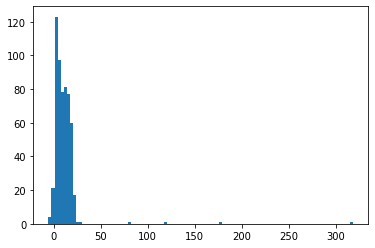

In [100]:
plt.hist(globular_cluster_data['parallax_over_error'],bins=100)
plt.show()

In [11]:
np.std(globular_cluster_data['parallax'])

0.2444858550166559

In [12]:

bound=[globular_cluster_data['parallax'].median()-3*globular_cluster_data['parallax'].std(),globular_cluster_data['parallax'].median()+3*globular_cluster_data['parallax'].std()]

In [13]:
truth1=gaia_not_eso['parallax']>=bound[0]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_1359/1683134010.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


In [14]:
gaia_not_eso['parallax'].min()

-0.5284445169587473

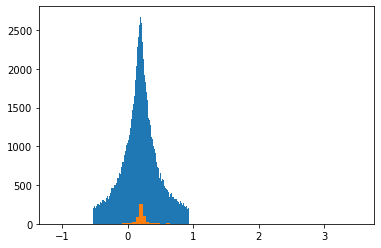

In [15]:
plt.hist(gaia_not_eso['parallax'],bins=100)
plt.hist(globular_cluster_data['parallax'],bins=90)
plt.show()

Even after the parallax cut of 3 sigma there are still plenty of sources.

After making a very conservative cut we are going to attempt to fit the BNN with error.

# 1.7 Making Data into Learning Format.

In [16]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']
input_cluster_data=pd.concat([globular_cluster_data, gaia_not_eso])[columns_parameters]

In [17]:
input_cluster_data

,ra,dec,parallax,VRAD,pmra,pmdec
0,5.345517,-72.084166,0.157613,-9.03,5.065448,-3.256621
1,5.393506,-72.148192,0.191817,-11.52,5.859635,-3.132667
2,5.402276,-72.122073,0.171836,-15.16,5.183397,-2.866585
3,5.415119,-72.047736,0.171036,-19.98,5.258597,-3.060259
4,5.432162,-72.087867,0.235197,-21.3,5.316276,-3.433750
...,...,...,...,...,...,...
95734,5.924421,-71.825522,0.036779,NaN,4.432527,-1.014558
95735,5.912720,-71.826915,0.422844,NaN,4.968408,-2.840847
95737,5.921315,-71.826686,0.028726,NaN,0.387750,-1.273945
95738,5.914717,-71.830051,0.374448,NaN,5.252119,-3.159406


In [18]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([globular_cluster_data, gaia_not_eso])[columns_error]

# Covariance Error matrix

In [19]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix

For the moment we don't need it to be very complex as we are going to only have two different cases, i.e whether or not a value has radial velocity. 

In [39]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [21]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)

# Definitions of the learning inputs

In [54]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix
learning_R=R
learning_initial_array=globular_cluster_data.to_numpy()

# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In [23]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Analysis')

In [24]:
%load_ext autoreload
%autoreload 2

# We are only using the Data which is in Gaia Eso now as we have a few bugs to fix.

In [108]:
gmm=XDGMM(2).fit(learning_input[0:len(globular_cluster_data)],Xerr=learning_error_covariance[0:len(globular_cluster_data)],R=R[0:len(globular_cluster_data)])
gmm.mu

array([[ 6.02803688e+00, -7.20784866e+01,  2.20581784e-01,
        -1.78522985e+01,  5.33205029e+00, -2.54037691e+00],
       [ 5.90612666e+00, -7.21903529e+01,  6.85779390e-02,
         3.78280000e+02,  1.17756499e+00, -1.63062733e+00]])

In [29]:
from scipy.stats import multivariate_normal
def pdf_xdgmm(inputs,alpha,components,V,mu):
    
    output=0
    for i in range(0,components):
        mean=mu[i]
        cov=V[i]
        output=output+alpha[i]*multivariate_normal.pdf(inputs,mean=mean,cov=cov)
    return output

(array([563.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([7.78106085e-99, 7.35210158e+11, 1.47042032e+12, 2.20563047e+12,
        2.94084063e+12, 3.67605079e+12, 4.41126095e+12, 5.14647111e+12,
        5.88168127e+12, 6.61689142e+12, 7.35210158e+12]),
 <BarContainer object of 10 artists>)

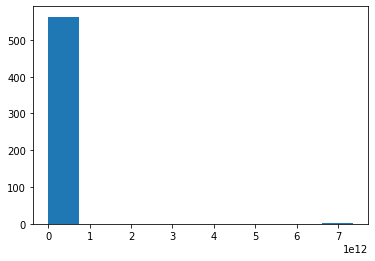

In [109]:
plt.hist(pdf_xdgmm(inputs=learning_input[0:len(globular_cluster_data)],alpha=gmm.alpha,components=gmm.n_components,V=gmm.V,mu=gmm.mu))

In [89]:
xbar=gmm.sample(size=10000).mean(axis=0)
sd=gmm.sample(size=10000).std(axis=0)

Plotting the parameters vs the expected values.

In [95]:
parallax=learning_input[0:len(globular_cluster_data)].transpose()[2]
pm_ra=learning_input[0:len(globular_cluster_data)].transpose()[4]
pm_dec=learning_input[0:len(globular_cluster_data)].transpose()[5]
vrad=learning_input[0:len(globular_cluster_data)].transpose()[3]

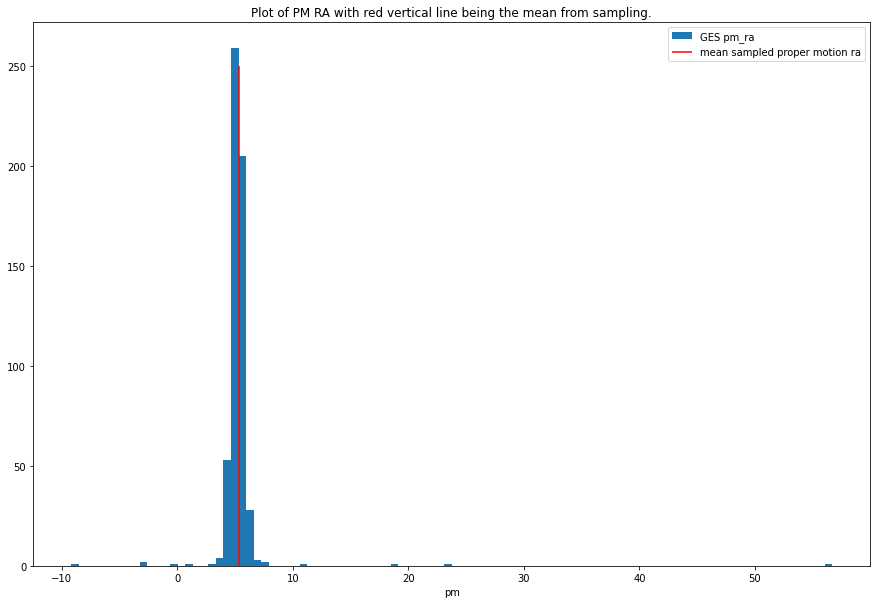

In [96]:
plt.figure(figsize=(15,10))
plt.title('Plot of PM RA with red vertical line being the mean from sampling.')
plt.hist(pm_ra,bins=100,label='GES pm_ra')
plt.vlines(xbar[4],ymin=0,ymax=250,colors='r',label='mean sampled proper motion ra')
plt.xlabel('pm')
plt.legend()
plt.show()

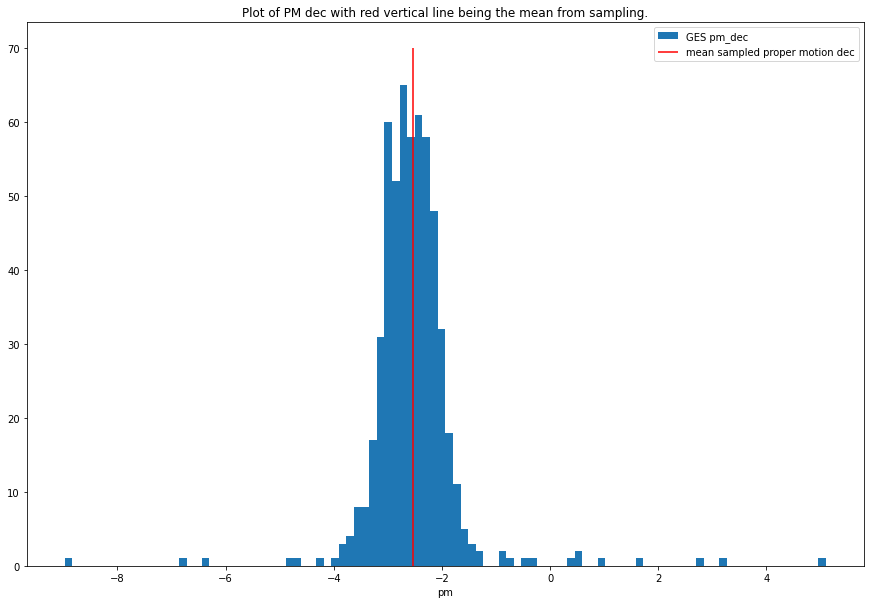

In [106]:
plt.figure(figsize=(15,10))
plt.title('Plot of PM dec with red vertical line being the mean from sampling.')
plt.hist(pm_dec,bins=100,label='GES pm_dec')
plt.vlines(xbar[5],ymin=0,ymax=70,colors='r',label='mean sampled proper motion dec')
plt.xlabel('pm')
plt.legend()
plt.show()

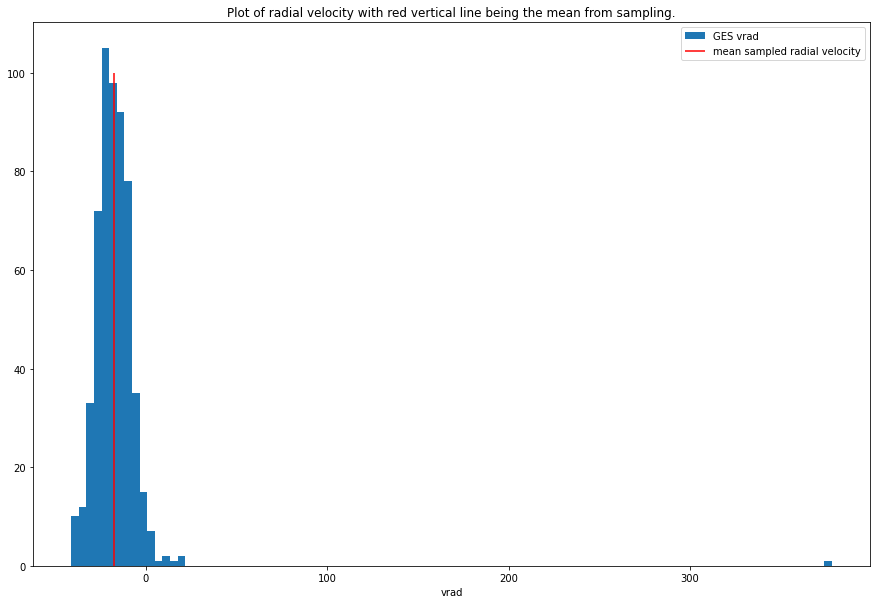

In [98]:
plt.figure(figsize=(15,10))
plt.title('Plot of radial velocity with red vertical line being the mean from sampling.')
plt.hist(vrad,bins=100,label='GES vrad')
plt.vlines(xbar[3],ymin=0,ymax=100,colors='r',label='mean sampled radial velocity')
plt.xlabel('vrad')
plt.legend()
plt.show()

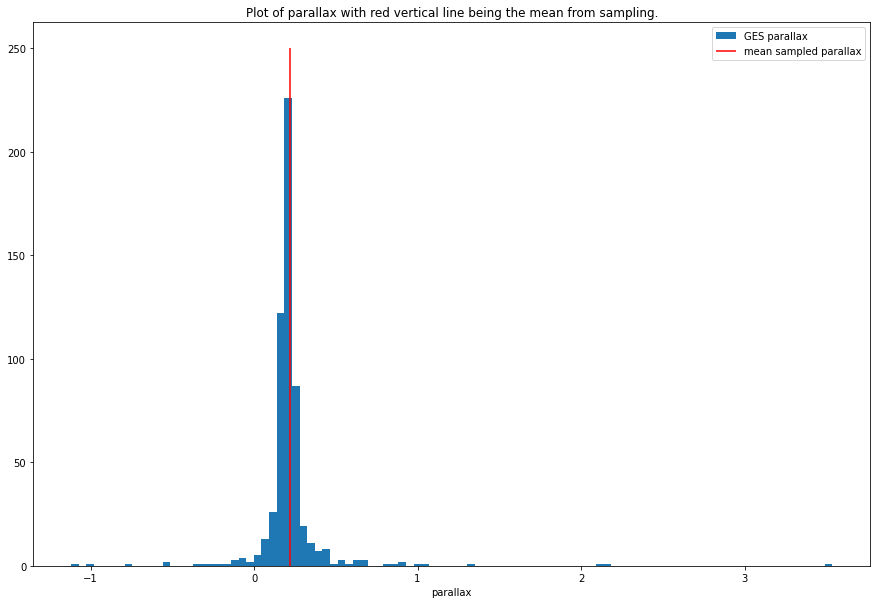

In [99]:
plt.figure(figsize=(15,10))
plt.title('Plot of parallax with red vertical line being the mean from sampling.')
plt.hist(parallax,bins=100,label='GES parallax')
plt.vlines(xbar[2],ymin=0,ymax=250,colors='r',label='mean sampled parallax')
plt.xlabel('parallax')
plt.legend()
plt.show()